In [1]:
# Importing required libraries

import re
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

data = pd.read_csv("IMDB Dataset.csv")
print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
data.shape

(50000, 2)

In [5]:
print(data.shape)
print(data.info())
print(data['sentiment'].value_counts())

(50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


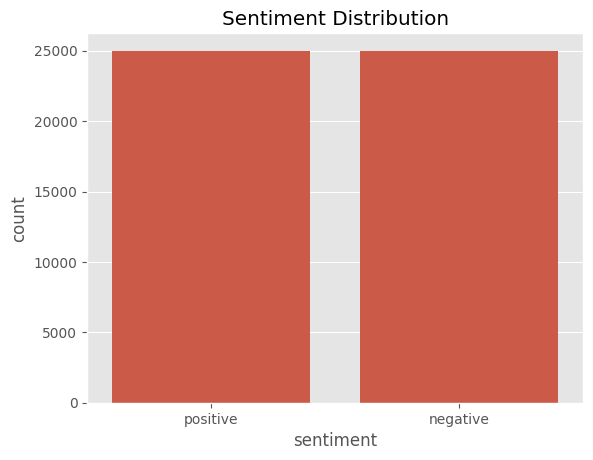

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="sentiment", data=data)
plt.title("Sentiment Distribution")
plt.show()

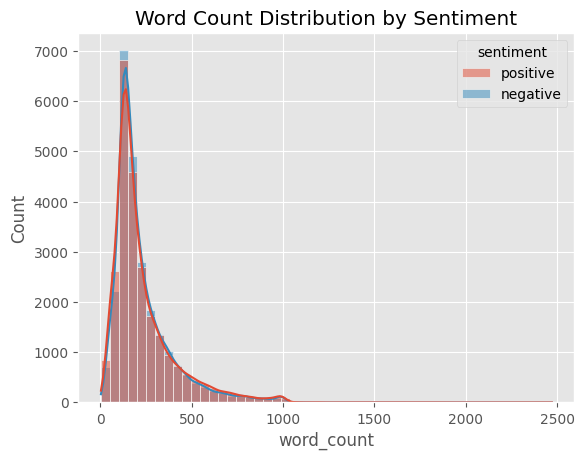

In [7]:
data['review_length'] = data['review'].apply(len)
data['word_count'] = data['review'].apply(lambda x: len(x.split()))

sns.histplot(data=data, x='word_count', hue='sentiment', bins=50, kde=True)
plt.title("Word Count Distribution by Sentiment")
plt.show()

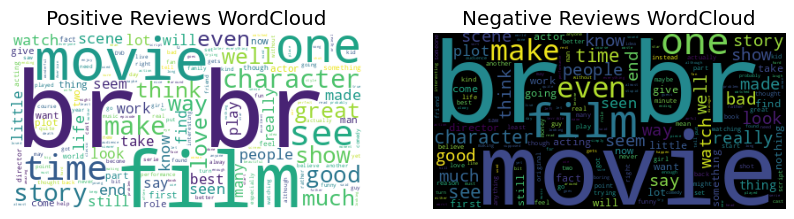

In [8]:
from wordcloud import WordCloud, STOPWORDS

pos_text = " ".join(data[data['sentiment']=="positive"]['review'])
neg_text = " ".join(data[data['sentiment']=="negative"]['review'])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(stopwords=STOPWORDS, background_color="white").generate(pos_text))
plt.title("Positive Reviews WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(stopwords=STOPWORDS, background_color="black").generate(neg_text))
plt.title("Negative Reviews WordCloud")
plt.axis("off")

plt.show()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,2), stop_words="english", max_features=20)
X = cv.fit_transform(data['review'])
bigram_freq = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out()).sum().sort_values(ascending=False)
print(bigram_freq.head(10))

br br              101188
ve seen              4168
br film              3007
br movie             2992
movie br             2358
special effects      2249
don know             2201
film br              2079
low budget           1824
looks like           1677
dtype: int64


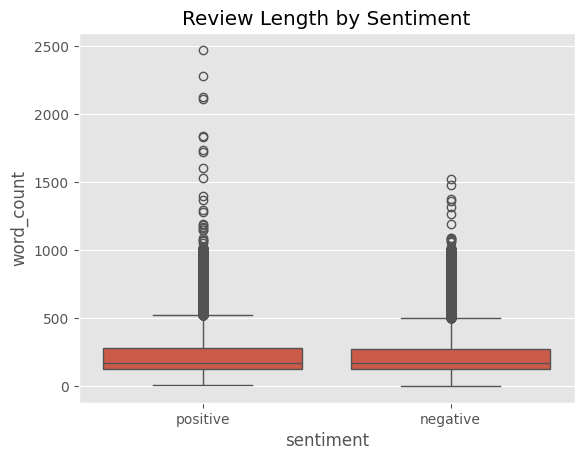

In [10]:
sns.boxplot(x='sentiment', y='word_count', data=data)
plt.title("Review Length by Sentiment")
plt.show()

In [11]:
# Checking one review entry
data["review"][12]

'So im not a big fan of Boll\'s work but then again not many are. I enjoyed his movie Postal (maybe im the only one). Boll apparently bought the rights to use Far Cry long ago even before the game itself was even finsished. <br /><br />People who have enjoyed killing mercs and infiltrating secret research labs located on a tropical island should be warned, that this is not Far Cry... This is something Mr Boll have schemed together along with his legion of schmucks.. Feeling loneley on the set Mr Boll invites three of his countrymen to play with. These players go by the names of Til Schweiger, Udo Kier and Ralf Moeller.<br /><br />Three names that actually have made them selfs pretty big in the movie biz. So the tale goes like this, Jack Carver played by Til Schweiger (yes Carver is German all hail the bratwurst eating dudes!!) However I find that Tils acting in this movie is pretty badass.. People have complained about how he\'s not really staying true to the whole Carver agenda but we

**Data Preprocessing**

In [17]:
import nltk
nltk.download('stopwords')

stopwords_list = set(stopwords.words('english'))

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    """
    Uses regex to find anything inside <...> and remove it
    """
    return TAG_RE.sub('', text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
class PreprocessData():
    """
    This class is a pipeline for cleaning text. It removes html tags,
    punctuations, numbers, single characters, multiple spaces, and stopwords.
    """
    def __init__(self):
        pass

    def preprocess_text(self, sentence):
        sentence = sentence.lower()

        # Remove html tags
        sentence = remove_tags(sentence)

        # Remove Punctuations & Numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)

        # Remove Single Characters
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove Multiple Spaces
        sentence = re.sub(r'\s+', ' ', sentence)

        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)

        return sentence

In [19]:
# Preprocessing a sample sentence
preprocess = PreprocessData()
preprocess.preprocess_text("There are some things worth mentioning that would imply that Boll did a good work on some areas of the film such as some nice boat and fighting scenes.")

'things worth mentioning would imply boll good work areas film nice boat fighting scenes '

In [20]:
# Building the preprocessed dataset

X = []
sentences = list(data['review'])

for sentence in sentences:
    X.append(preprocess.preprocess_text(sentence))

In [21]:
# Target label mapping

Y = data['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}

Y = np.array(Y.map(sentiment_map))
Y[:10]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1])

**Train-Test split**

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [23]:
# Using tokenizer to build a vocabulary dictionary for mapping words → unique integers

from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")

In [24]:
tokenizer.fit_on_texts(X_train)


In [25]:
# Converting each training sentence into a sequence of integers using the word index built above.

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [26]:
# Unique tokens from the training text

vocabulary_length = len(tokenizer.word_index) + 1 # We add +1 because index 0 is reserved for padding tokens
vocabulary_length


92395

In [27]:
# Padding

from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 250

X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

**Training**

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()

In [29]:
# Embedding layer: Converts word indices (integers) into dense vector embeddings
model.add(Embedding(10000, 128, input_shape=(maxlen,)))

# SimpleRNN Layer: Processes the sequence of embeddings one step at a time
model.add(SimpleRNN(128, activation = 'relu'))

# Dense Layer: Final classification layer
model.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,025 (5.01 MB)

 Trainable params: 1,313,025 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Creating an instance of EarlyStopping Callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss',          # what metric to watch → here it's validation loss
    patience = 5,                  # how many epochs to wait before stopping if no improvement
    restore_best_weights = True    # after stopping, roll back to the best model weights
)

early_stopping


In [32]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
# Training the model

history = model.fit(X_train, Y_train, epochs = 20, batch_size = 32,
          validation_split = 0.2,
          callbacks = [early_stopping]
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 131ms/step - accuracy: 0.6630 - loss: 0.6788 - val_accuracy: 0.7991 - val_loss: 0.4625
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 123ms/step - accuracy: 0.8795 - loss: 0.3002 - val_accuracy: 0.8705 - val_loss: 0.3266
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 120s 120ms/step - accuracy: 0.9228 - loss: 0.2054 - val_accuracy: 0.8645 - val_loss: 0.3449
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 120s 120ms/step - accuracy: 0.9404 - loss: 0.1583 - val_accuracy: 0.8342 - val_loss: 0.3835
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 114s 114ms/step - accuracy: 0.9342 - loss: 0.1682 - val_accuracy: 0.8560 - val_loss: 0.4084
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 151s 123ms/step - accuracy: 0.9595 - loss: 0.1134 - val_accuracy: 0.8536 - val_loss: 0.5096
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 134s 115ms/step - accuracy: 0.9619 - loss: 0.1007 - val_accuracy: 0.8476 - val_loss: 0.4346


In [34]:
result = model.evaluate(X_test, Y_test, verbose = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8702 - loss: 0.3273


In [35]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.869700014591217
Test Loss: 0.33084094524383545


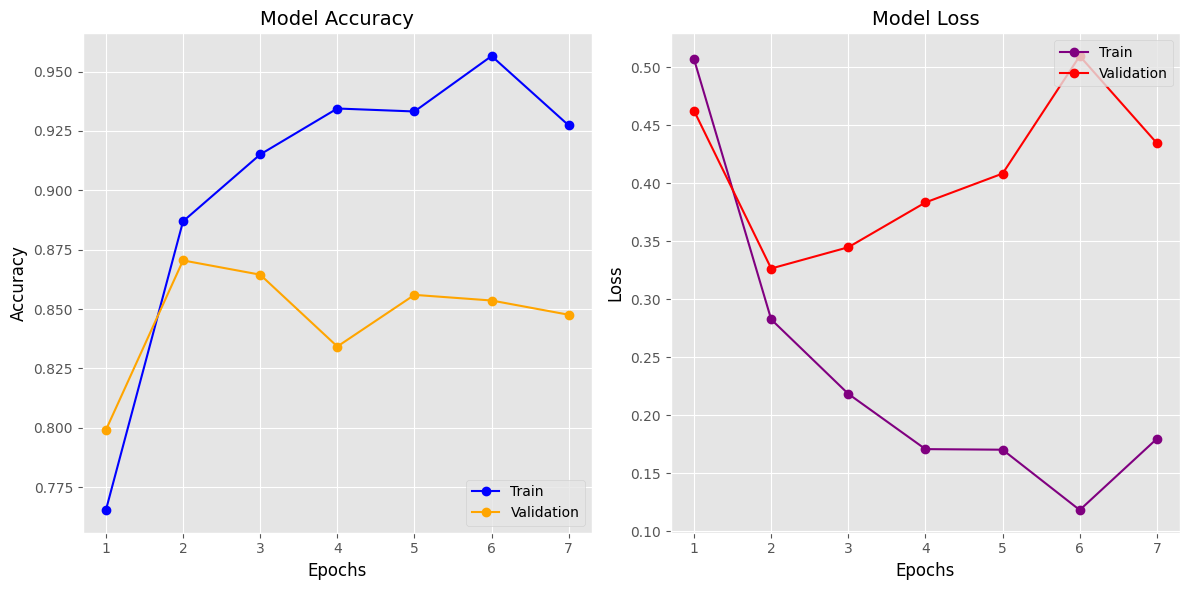

In [36]:
# Number of epochs
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], color = 'blue', marker = 'o')
plt.plot(epochs, history.history["val_accuracy"], color = 'orange', marker = 'o')
plt.title("Model Accuracy", fontsize = 14)
plt.xlabel("Epochs", color = 'black')
plt.ylabel("Accuracy", color = 'black')
plt.legend(['Train', 'Validation'], loc = "lower right")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], color = 'purple', marker = 'o')
plt.plot(epochs, history.history["val_loss"], color = 'red', marker = 'o')
plt.title("Model Loss", fontsize = 14)
plt.xlabel("Epochs", color = 'black')
plt.ylabel("Loss", color = 'black')
plt.legend(['Train', 'Validation'], loc = "upper right")

plt.tight_layout()
plt.show()